# Strain Amplitude distribution (SAD)

Juan Urrutia, December 2025

## Imports

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy import optimize, stats
from scipy.misc import derivative
from scipy.optimize import root_scalar, newton
from scipy.interpolate import RegularGridInterpolator,interp1d,LinearNDInterpolator, BSpline, make_interp_spline
from scipy.integrate import quad, fixed_quad, quadrature, simps, romberg, trapezoid, nquad, dblquad, cumulative_trapezoid, trapz
from scipy.stats import qmc, gaussian_kde, rv_continuous
from IPython.display import display, Math
import pickle
from pathlib import Path
import os
import pandas as pd
from sklearn.neighbors import KernelDensity
import argparse
import time
import sys
from joblib import Parallel, delayed

In [59]:
# Set font to Times New Roman and configure plot style
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['mathtext.fontset'] = 'stix'  # For math text to match Times
plt.rcParams['axes.linewidth'] = 1.5  # Thicker frame
plt.rcParams['xtick.major.width'] = 1.5  # Thicker tick marks
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['xtick.labelsize'] = 14  # Larger tick labels
plt.rcParams['ytick.labelsize'] = 14

## General Cosmology

In [5]:
#Constants and cosmological parameters 
kpc=1;
s=1;
kg=1;
meter = 3.24e-20*kpc;
G = 6.674e-11*meter**3/kg/s**2;
c = 2.998e8*meter/s;
Msun = 1.99e30*kg;
h = 0.674;
𝛔8 = 0.811;
ΩM = 0.315;
Ωb = 0.0493;
zeq = 3402;
T0 = 2.7255;
ns = 0.965;
year = 3.15576*1e7
fyr = 1 / year

#Densities
def solve_Omega_R():
    return ΩM * (1 + zeq)**3 / (1 + zeq)**4    
ΩR = solve_Omega_R()
ΩL = 1 - ΩM - ΩR
Ωc = ΩM - Ωb
H0 = 100 * h * meter
def AH(z):
    return np.sqrt(ΩM * (1 + z)**3 + ΩR * (1 + z)**4 + ΩL)
def H(z):
    return H0 * AH(z)
def ΩMz(z):
    return ΩM * (1 + z)**3 / AH(z)**2
def ΩLz(z):
    return ΩL / AH(z)**2
𝜌c = 3 * H0**2 / (8 * np.pi * G)
Ω0 = 0.32
Ωb = 0.05
𝜌0 = Ω0 * 277.5 * h**2
𝜌M0 = 𝜌c * ΩM / Msun * kpc**3
keq = H(zeq)/(1+zeq)*kpc/c;

# Distances
logz_grid = np.arange(-6, 4.01, 0.01)
z_vals = 10 ** logz_grid
dc_points = []
for z in z_vals:
    if z == 0:
        dc_points.append(0)
    else:
        integrand = lambda x: c / H(x) / kpc
        val, _ = quad(integrand, 0, z,epsabs=1e-12,epsrel=1e-12)
        dc_points.append(val)
dc = interp1d(z_vals, dc_points, kind='linear', fill_value="extrapolate")

def DVc(z):
    dz = 1e-2
    dcdz = (dc(z + dz) - dc(z- dz)) / (2*dz)
    return 4 * np.pi * dc(z)**2 * dcdz
    
def zDLf(DL):
    def func(z):
        return (1 + z) * dc(z) - DL
    sol = root_scalar(func, bracket=[0, 2e3], method='brentq')
    return sol.root if sol.converged else np.nan

def DLz(z):
    return (1 + z) * dc(z)
    
def tza(z):
    integrand = lambda x: 1 / ((1 + x) * H(x))
    return quad(integrand, z, np.inf)[0]

tz_points = np.concatenate([np.linspace(-0.999, 0, 200), np.linspace(0.0001, 100, 300)])
tz_vals = [tza(z) for z in tz_points]
tz = interp1d(tz_points, tz_vals, kind='cubic', fill_value="extrapolate")
zt = interp1d(tz_vals, tz_points, kind='cubic', fill_value="extrapolate")

#Growth of perturbations
def Dg(z):
    return 5/2*ΩMz(z)/(ΩMz(z)**(4/7)-ΩLz(z)+(1+ΩMz(z)/2)*(1+ΩLz(z)/70))/(1+z)/0.78694
def 𝛿(z):
    return 3 * (12 * np.pi)**(2/3) / 20 * (1 + 0.123 * np.log10(ΩL * (1 + z)**3 / (ΩL * (1 + z)**3 + 1 -ΩL)))
def 𝛿c(z):
    return 3 / 5 * (3 * np.pi / 2)**(2/3) / Dg(z)

In [6]:
# Matter power spectrum

def T(kk):
    ksilk = 1.6 * (Ωb * h**2)**0.52 * (ΩM * h**2)**0.73 * (1 + (10.4 * ΩM * h**2)**-0.95) / 1e3
    a1 = (46.9 * ΩM * h**2)**0.67 * (1 + (32.1 * ΩM * h**2)**-0.532)
    a2 = (12.0 * ΩM * h**2)**0.424 * (1 + (45.0 * ΩM * h**2)**-0.582)
    b1 = 0.944 * (1 + (458 * ΩM * h**2)**-0.708)**-1
    b2 = (0.395 * ΩM* h**2)**(-0.026)
    alpha_cnum = a1**(-Ωb / ΩM) * a2**(-(Ωb / ΩM)**3)
    beta_cnum = 1 / (1 + b1 * ((Ωc / ΩM)**b2 - 1))
    def q(k): return k / (13.41 * keq)
    def C1(k, alpha_c): return 14.2 / alpha_c + 386 / (1 + 69.9 * q(k)**1.08)
    def To1(k, alpha_c, beta_c): return np.log(np.e + 1.8 * beta_c * q(k)) / (np.log(np.e + 1.8 * beta_c * q(k)) + C1(k, alpha_c) * q(k)**2)
    s2 = 44.5 * np.log(9.83 / (ΩM * h**2)) / np.sqrt(1 + 10 * (Ωb * h**2)**(3/4)) * 1e3
    def f(k): return 1 / (1 + (k * s2 / 5.4)**4)
    def Tc(k): return f(k) * To1(k, 1, beta_cnum) + (1 - f(k)) * To1(k, alpha_cnum, beta_cnum)
    def jo(x): return np.sin(x) / x
    def g2(y): return y * (-6 * np.sqrt(1 + y) + (2 + 3 * y) * np.log((np.sqrt(1 + y) + 1) / (np.sqrt(1 + y) - 1)))
    zeq = 2.50e4 * ΩM * h**2 * (T0 / 2.7)**-4
    b3 = 0.313 * (ΩM * h**2)**-0.419 * (1 + 0.607 * (ΩM * h**2)**0.674)
    b4 = 0.238 * (ΩM * h**2)**0.223
    zd = 1291 * (ΩM * h**2)**0.251 / (1 + 0.659 * (ΩM * h**2)**0.828) * (1 + b3 * (Ωb * h**2)**b4)
    Rd = 31.5 * Ωb * h**2 * (T0 / 2.7)**-4 * (zd / 1e3)**-1
    alpha_b = 2.07 * keq * s2 * (1 + Rd)**(-3/4) * g2((1 + zeq) / (1 + zd))
    beta_b = 0.5 + Ωb / ΩM + (3 - 2 * Ωb / ΩM) * np.sqrt(1 + (17.2 * ΩM * h**2)**2)
    beta_node = 8.41 * (ΩM * h**2)**0.435
    def s3(k): return s2 / (1 + (beta_node / (k * s2))**3)**(1/3)
    def Tb(k): return (To1(k, 1, 1) / (1 + (k * s2 / 5.2)**2) + alpha_b / (1 + (beta_b / (k * s2))**3) * np.exp(-(k / ksilk)**1.4)) * jo(k * s3(k))
    return Ωb / ΩM * Tb(kk) + Ωc / ΩM * Tc(kk)
    
def CapitalDelta(k):
    delta_h = 0.00005
    return np.sqrt(delta_h**2 * (c * k / H0)**(3 + ns) * np.abs(T(k))**2)

def P(k):
    return CapitalDelta(k)**2 * (2 * np.pi**2) / k**3

def j1(x):
    return (x * np.cos(x) - np.sin(x)) / x**2

R8 = 8 / h * 1e3

### DM dependent terms

In [7]:
# Matter density variance in CDM 
def WFT(x):
   return 3*(np.sin(x)-x*np.cos(x))/(x**3)
def 𝛔f(M):
    def r(Mc):
        return (3*Mc/(4*np.pi*𝜌M0))**(1/3)
    val, _ = quad(lambda logk:10**(3*logk) * WFT(r(M)*10**logk)**2 * P(10**logk), -20, 20, epsrel=1e-2)
    return 1/(np.sqrt(2)*np.pi) * np.sqrt(np.log(10)*val)
    
log10m_vals = np.arange(-16, 32.1, 0.1)
m_vals = 10**log10m_vals
𝛔2_vals = np.array([𝛔f(m) for m in m_vals])
𝛔2_interp = make_interp_spline(m_vals, 𝛔2_vals, k=1)
def 𝛔CDM2(M):
    ref_mass = 2.7803939422903778e14
    return 𝛔8 / 𝛔2_interp(ref_mass) * 𝛔2_interp(M)
𝛔CDM_vals = np.array([𝛔CDM2(m) for m in m_vals])
𝛔CDM = make_interp_spline(m_vals,𝛔CDM_vals, k=1)
d𝛔dM= 𝛔CDM.derivative()

## GW physics

In [8]:
# Unit conversions and placeholders
def McEta(m1, m2):
    return np.array([
        (m1 * m2) ** (3.0 / 5.0) / (m1 + m2) ** (1.0 / 5.0),
        (m1 * m2) / (m1 + m2) ** 2.0])

def m1m2(Mc, eta):
    M = Mc / (eta ** (3.0 / 5.0))
    delta = np.sqrt(1.0 - 4.0 * eta)
    m1 = 0.5 * M * (1.0 + delta)
    m2 = 0.5 * M * (1.0 - delta)
    return np.array([m1, m2])

def tins(fb, Mc, z):
    return (5.0 / 64.0) * (1.0 + z) * (G * Mc * Msun) ** (-5.0 / 3.0) * (2.0 * np.pi * fb) ** (-8.0 / 3.0) * c ** 5.0

def tenv(Mchirp, fb, alpha, beta, fref, z):
    return tins(fb, Mchirp, z) * ((Mchirp / 10.0 ** 9.0) ** (alpha - beta) * (fb / fref) ** alpha)

def dtdlnf(fb, Mc_val, z, alpha, beta, fref):
    t_env = tenv(Mc_val, fb, alpha, beta, fref, z)
    t_ins = tins(fb, Mc_val, z)
    return (2.0 / 3.0) * 1.0 / (1.0 / t_env + 1.0 / t_ins)

def McA(A, z, fgw):
    return ((A ** (3.0 / 5.0)) * (((1.0 + z) * dc(z) * kpc) ** (3.0 / 5.0)) * (c ** (12.0 / 5.0)) / (2.0 * (2.0 ** (3.0 / 5.0)) * ((fgw / s) ** (2.0 / 5.0)) * (np.pi ** (2.0 / 5.0)) * G)) * (1.0 / Msun)

dlnMcdlnA = 0.6


## EPS structure formation and DM halo merger rates

In [9]:
#Basic probabilities 
def pfcST(δ1,S1): return 0.114963*S1**(-3/2)*np.e**(-0.4*δ1**2/S1)*δ1*(1+1.06923*(δ1**2/S1)**(-3/10))
def δel(δ1,S1): return np.sqrt(0.707)*δ1*(1+0.485*(0.707*δ1**2/S1)**(-0.615))
def pfc(δ1,S1,δ2,S2): 
    return np.e**(-(0.840833*δ1+S2**0.615*(0.504729/δ1**0.23-0.504729/δ2**0.23)-0.840833*δ2)**2/(2*(S1-S2)))*(S1-S2)**(-3/2)*(1+0.90121*(δ1**2/S1)**(3/10))*((S1*δ2**2)/(S2*δ1**2))**(3/10)*np.abs(0.840833*δ1+S2**(0.615)*(0.504729/δ1**0.23-0.504729/δ2**0.23)-0.840833*δ2)/(np.sqrt(2*np.pi)*(1+0.90121*(δ2**2/S2)**(3/10)))
def pcond(δp,𝛔p,δm,𝛔m):
    return pfc(δp,𝛔p**2,δm,𝛔m**2)*pfcST(δm,𝛔m**2)/pfcST(δp,𝛔p**2)
#halo mass functions
def dndlogm(M,z):
    return 𝜌0*2*𝛔CDM(M)*np.abs(d𝛔dM(M))*pfcST(δc(z),𝛔CDM(M)**2)

In [10]:
# Probability of a  merger
def dPdM0dt(M,M0,z):
    S = 𝛔CDM(M)**2
    S0 = 𝛔CDM(M0)**2
    a = 0.707
    p = 3/10
    q = 8/10
    nu = 𝛿c(z)**2/S
    nu0 = 𝛿c(z)**2/S0
    A = (1+(a*(𝛿c(z)**2/S0))**(-p))**(-1)
    def ddelta(z):
        return np.abs((δel(𝛿c(z+1e-2),S0)-δel(𝛿c(z-1e-2),S0))/(2*1e-2))
    return  A/np.sqrt(2*np.pi)*(1+(a*nu)**(-p))*(1+(q*nu0)**(-p))/(1+(q*nu)**(-p))*(S/(S0*(S-S0)))**(3/2)*np.exp(-q*(nu0-nu)/2)*ddelta(z)*(1+z)*H(z)*np.abs(2*𝛔CDM(M0)*d𝛔dM(M0))

In [11]:
# CDM merger rate in elliptical collapse
def Rloglog(M1, M2, z):
    Mp =np.minimum(M1, M2)
    M = M1 + M2
    return np.log(10)**2*dndlogm(Mp,z)*M*dPdM0dt(Mp,M,z)

In [12]:
# We first compute the stellar halo mass relation, 
def Az(z):
    return 0.046 * (1.0 + z) ** (-0.38)

def logMaz(z):
    return 11.79 + 0.2 * z

def Gamma_z(z):
    return 0.709 * (1.0 + z) ** (-0.18)

def Beta_z(z):
    return 0.043 * z + 0.92

def Mstar(Mh, z):
    denom = (Mh / (10.0 ** logMaz(z))) ** (-Beta_z(z)) + (Mh / (10.0 ** logMaz(z))) ** (Gamma_z(z))
    return 2.0 * Az(z) * Mh * (denom ** (-1.0))

def Mbulge(mstar):
    return 0.615 * mstar

def logMBH(Mh, z, a, b, c):
    Ms = Mstar(Mh, z)
    return a + b * np.log10(Ms / (10.0 ** 11)) + c * np.log10(1.0 + z)

def logMh(MBH, z, a, b, c):
    def f(Mh):
        return logMBH(Mh, z, a, b, c) - np.log10(MBH)
    Mh_root = optimize.newton(f, np.log10(MBH) + 2.0)
    return np.log10(Mh_root)

# We then connect the mass of the black hole to the mass of the host galaxy

def pMBH(mbh, Mh, z, a, b, c, sigma):
    mu = logMBH(Mh, z, a, b, c)
    return stats.norm.pdf(np.log10(mbh), loc=mu, scale=sigma)

def logmvMin(mbh, z, a, b, c, sigma):
    def f(x):
        return np.log10(pMBH(mbh, x, z, a, b, c, sigma)) + 3.0
    try:
        r = root_scalar(f, bracket=[1.0e4, 1.0e18])
        x_root = r.root
    except Exception:
            x_root =  7
    return np.log10(x_root)

## Nanograv data and SMBH data

In [13]:
# Get the current notebook directory (adjust as needed)
notebook_dir = Path.cwd()
data_dir = notebook_dir / "30f_fs{hd}_ceffyl"

# Load the numpy arrays
prob = np.load(data_dir / "density.npy")[0]  # First element
L10rho = np.load(data_dir / "log10rhogrid.npy")
fNG15 = np.load(data_dir / "freqs.npy")

# Calculate the frequency spacing (difference between first two elements)
delta_fNG15 = np.diff(fNG15)[0]

# Create data pairs: transpose to get arrays of (L10rho, exp(prob[j]))
data = [np.column_stack((L10rho, np.exp(prob[j]))) for j in range(len(prob))]

# Create linear interpolation functions for each dataset
# interp1d creates a function that interpolates the data
PNG15 = [interp1d(d[:, 0], d[:, 1], kind='linear', fill_value='extrapolate') 
         for d in data]

# Create tuples of (frequency, interpolation_function)
# Each element is (fNG15[i], PNG15[i])
PNG15 = list(zip(fNG15, PNG15))

# Keep only the first 14 elements
PNG15 = PNG15[:14]


In [14]:
# Load the pre-processed data
with open("agn_data.pkl", "rb") as f:
    data = pickle.load(f)

# Extract the variables
broadLINEAGNdata = data["broadLINEAGNdata"]
otherAGNdata = data["otherAGNdata"]
dynamicallymeasured = data["dynamicallymeasured"]

print(f"Loaded {len(broadLINEAGNdata)} broad AGN data points")
print(f"Loaded {len(otherAGNdata)} other AGN data points")
print(f"Loaded {len(dynamicallymeasured)} dynamically measured data points")

def convert_to_numeric(data_list):
    numeric_data = []
    
    for item in data_list:
        try:
            # Force conversion to float
            numeric_item = [
                [float(item[0][0]), float(item[0][1])],  # [x, y]
                [float(item[1][0]), float(item[1][1])]   # [xerr, yerr]
            ]
            
            # Only keep if all values are valid numbers
            if all(np.isfinite([numeric_item[0][0], numeric_item[0][1], 
                               numeric_item[1][0], numeric_item[1][1]])):
                numeric_data.append(numeric_item)
        except:
            pass  # Skip invalid entries
    
    return numeric_data

broadLINEAGNdata = np.array(convert_to_numeric(broadLINEAGNdata), dtype=np.float64)
otherAGNdata = np.array(convert_to_numeric(otherAGNdata), dtype=np.float64)
dynamicallymeasured = np.array(convert_to_numeric(dynamicallymeasured), dtype=np.float64)


Loaded 235 broad AGN data points
Loaded 27 other AGN data points
Loaded 70 dynamically measured data points


## BH merger rates, luminosity function and time residuals

### Merger rate

In [15]:
# Montecarlo integral over the spread of the SMBH mass stellar mass relation 

def Rastro_qmc(m1, m2, z, a, b, sigma, n):
    
    # Convert to arrays
    m1 = np.atleast_1d(m1)
    m2 = np.atleast_1d(m2)
    z = np.atleast_1d(z)
    m1, m2, z = np.broadcast_arrays(m1, m2, z)
    
    n_points = m1.size
    m1_flat = m1.ravel()
    m2_flat = m2.ravel()
    z_flat = z.ravel()
    
    # Generate Sobol samples
    sob = qmc.Sobol(d=2, scramble=False, seed=None)
    u = sob.random(n)
    
    # Compute bounds for all points (vectorize if possible)
    lo = np.array([
        min(logmvMin(m1_flat[i], z_flat[i], a, b, 0, sigma),
            logmvMin(m2_flat[i], z_flat[i], a, b, 0, sigma))
        for i in range(n_points)
    ])

    hi = 18
    
    # Reshape for broadcasting: (n_points, 1) × (1, n_samples)
    lo = lo[:, np.newaxis]
    
    # Generate all M1, M2 samples for all points
    
    logM1 = lo + (hi - lo) * u[np.newaxis, :, 0]
    logM2 = lo + (hi - lo) * u[np.newaxis, :, 1]
    
    M1 = 10.0 ** logM1
    M2 = 10.0 ** logM2
    
    # Broadcast m1, m2, z to match shape
    m1_bc = m1_flat[:, np.newaxis]
    m2_bc = m2_flat[:, np.newaxis]
    z_bc = z_flat[:, np.newaxis]
    
    # Compute all integrands (if Rloglog and pMBH support this broadcasting)
    vals = (
        Rloglog(M1, M2, z_bc)
        * pMBH(m1_bc, M1, 0.0, a, b, 0.0, sigma)
        * pMBH(m2_bc, M2, 0.0, a, b, 0.0, sigma)
    )
    
    # Compute integrals for all points
    area = (hi - lo.ravel()) ** 2
    results = area * np.mean(vals, axis=1)
    
    return results[0] if n_points == 1 else results.reshape(m1.shape)

In [16]:
# Analytical fit
def dR_dlnM_ModelII(Mc, z, R0_sec, M_star, c, d, z0):

    """Analytic Merger Rate dR/dM. R0_sec must be in s^-1 kpc^-3."""
    mass_term = (Mc / 1e10)**c *np.exp(-Mc / M_star)
    redshift_term = (1.0 + z)**d * np.exp(-z / z0)
    return (R0_sec) * mass_term * redshift_term*10**9

def dR_dlnM_int_II(R0_sec, M_star, c, d, z0, m_range=(1e7, 1e11), m_points=40, logz_range=(-5, np.log10(3.0)), z_points=40):
     
    log_Mc_grid = np.linspace(np.log10(m_range[0]), np.log10(m_range[1]), m_points)
    log_z_grid = np.linspace(logz_range[0], logz_range[1], z_points)
    Mc_grid = 10**log_Mc_grid
    z_grid = 10**log_z_grid
    values = np.zeros((m_points,  z_points))
    
    for i, Mc in enumerate(Mc_grid):
        for j, z in enumerate(z_grid):
            try:
                values[i, j] = np.log10(dR_dlnM_ModelII(Mc, z, R0_sec, M_star, c, d, z0))
            except:
                values[i, j] = 0.0

     # Build interpolator
    interpolator = RegularGridInterpolator(
        (log_Mc_grid, log_z_grid),
        values,
        method='linear',
        bounds_error=False,
        fill_value=None)
    
    # Return a callable function
    def Rastro_interp(Mc,eta, z):
        # Convert all inputs to arrays (handles both scalar and array inputs)
        Mc = np.atleast_1d(Mc)
        z = np.atleast_1d(z)
    
        # Transform to log space with safety bounds
        log_mc = np.log10(np.maximum(Mc, 1e3))
        log_z = np.log10(np.maximum(z, 1e-10))
    
        # Create points array for interpolation
        points = np.column_stack([log_mc, log_z])
    
        # Interpolate and transform back from log space
        result = 10**interpolator(points)
    
        # Return scalar if input was scalar, otherwise return array
        return result[0] if result.shape[0] == 1 else result

    return Rastro_interp

In [17]:
# to save a file for later interpolate the merger rate 

def build_and_save_Rastro_grid(a, b, sigma, n=2**14, m_range=(1e7, 1e11), m_points=30, logz_range=(-3, np.log10(3.0)), z_points=30, filename='Rastro_grid.npz'):
    
    # Create grids
    log_m1_grid = np.linspace(np.log10(m_range[0]), np.log10(m_range[1]), m_points)
    log_m2_grid = np.linspace(np.log10(m_range[0]), np.log10(m_range[1]), m_points)
    log_z_grid = np.linspace(logz_range[0], logz_range[1], z_points)
    
    m1_grid = 10**log_m1_grid
    m2_grid = 10**log_m2_grid
    z_grid = 10**log_z_grid
    
    values = np.zeros((m_points, m_points, z_points))
    
    print(f"Computing grid:{m_points*m_points*z_points} points")
    
    total = m_points * m_points * z_points
    count = 0
    
    for i, m1 in enumerate(m1_grid):
        for j, m2 in enumerate(m2_grid):
            for k, z in enumerate(z_grid):
                try:
                    values[i, j, k] = np.log10(Rastro_qmc(m1, m2, z, a, b, sigma, n))
                except:
                    values[i, j, k] = 0.0
                
                count += 1
                if count % 200 == 0:
                    print(f"  {count}/{total} ({100*count/total:.1f}%)")
    
    # Save everything as numpy arrays
    np.savez(filename,
             log_m1_grid=log_m1_grid,
             log_m2_grid=log_m2_grid,
             log_z_grid=log_z_grid,
             values=values,
             a=a,
             b=b,
             sigma=sigma,
             n=n)
    
    print(f"✓ Saved grid data to {filename}")
    print(f"  File size: {os.path.getsize(filename) / 1024:.1f} KB")

In [18]:
# to load the interpolating file with the merger rate 

def load_Rastro_interpolator(filename='Rastro_grid.npz', method='linear'):
    
    data = np.load(filename)
    
    log_m1_grid = data['log_m1_grid']
    log_m2_grid = data['log_m2_grid']
    log_z_grid = data['log_z_grid']
    values = data['values']
    
    # Print info
    print(f"✓ Loaded grid from {filename}")
    print(f"  Parameters: a={data['a']}, b={data['b']}, sigma={data['sigma']}")
    print(f"  Grid shape: {values.shape}")
    print(f"  m1 range: [{10**log_m1_grid[0]:.1e}, {10**log_m1_grid[-1]:.1e}]")
    print(f"  z range: [{10**log_z_grid[0]:.1e}, {10**log_z_grid[-1]:.1e}]")
    
    # Build interpolator
    interpolator = RegularGridInterpolator(
        (log_m1_grid, log_m2_grid, log_z_grid),
        values,
        method=method,
        bounds_error=False,
        fill_value=None)
    
    # Return a callable function
    def Rastro_interp(m1, m2, z):
        # Convert all inputs to arrays (handles both scalar and array inputs)
        m1 = np.atleast_1d(m1)
        m2 = np.atleast_1d(m2)
        z = np.atleast_1d(z)
    
        # Transform to log space with safety bounds
        log_m1 = np.log10(np.maximum(m1, 1e3))
        log_m2 = np.log10(np.maximum(m2, 1e3))
        log_z = np.log10(np.maximum(z, 1e-20))
    
        # Create points array for interpolation
        points = np.column_stack([log_m1, log_m2, log_z])
    
        # Interpolate and transform back from log space
        result = 10**interpolator(points)
    
        # Return scalar if input was scalar, otherwise return array
        return result[0] if result.shape[0] == 1 else result

    return Rastro_interp

### Luminosity function computation

In [19]:
def dNdlog10Alogf(R, logA, fgw, pbh, fref, alpha, beta, n_outer=2**14):
    
    # Check if logA is an array or scalar
    logA = np.atleast_1d(logA)
    is_scalar = logA.size == 1
    
    # Create z grid for interpolation
    logz_grid = np.linspace(-10, np.log10(2.99), 100)
    z_grid = 10**logz_grid
    
    # Initialize results array
    results = np.zeros(logA.size)
    
    # Loop over each logA value
    for i, logA_val in enumerate(logA):

        # Create interpolator for Mc(z) for this specific logA value
        
        Mc_grid = np.array([McA(10**logA_val, zi, fgw) for zi in z_grid])
        Mc_interp = interp1d(z_grid, Mc_grid, kind='linear', fill_value='extrapolate')
        
        # Generate Sobol samples
        sob = qmc.Sobol(d=2, scramble=True, seed=None)
        u = sob.random(n_outer)
        
        # Map to integration domain
        eta_lo, eta_hi = 1e-3, 0.24999
        logz_lo, logz_hi = -10, np.log10(2.99)  # Integration in log10(z)
        
        # Sample uniformly in eta and log10(z)
        eta = eta_lo + (eta_hi - eta_lo) * u[:, 0]
        logz = logz_lo + (logz_hi - logz_lo) * u[:, 1]
        
        # Convert back to z
        z = 10**logz
        
        # Evaluate Mc and masses
        Mc = Mc_interp(z)
        
        # Compute integrand with Jacobian for log10(z)
        
        jacobian = z * np.log(10)
        
        vals = (
            np.log(10) * dlnMcdlnA * jacobian * DVc(z) / (1 + z) 
            * pbh * R(Mc, eta, z) 
            * dtdlnf(2*fgw/(1+z), Mc, z, alpha, beta, fref)
        )
        
        # Compute integral - area is now in (eta, log10(z)) space
        area = (eta_hi - eta_lo) * (logz_hi - logz_lo)
        results[i] = area * np.mean(vals)
    
    # Return scalar if input was scalar, otherwise return array
    return results[0] if is_scalar else results

### Fourier coefficients

Now we need to make a sampling function from interpolating functions, we will use this a lot

In [20]:
def sample_from_pdf(pdf_func, x_min, x_max, size=1, grid_size=2000, extrapolate=False, random_state=None):
    
    if x_max <= x_min:
        raise ValueError("x_max must be greater than x_min.")

    # RNG setup
    if isinstance(random_state, np.random.Generator):
        rng = random_state
    else:
        rng = np.random.default_rng(random_state)

    # Build grid over [x_min, x_max]
    xs = np.linspace(x_min, x_max, grid_size)
    fx = np.asarray([pdf_func(x) for x in xs])

    # Validate PDF values
    if np.any(np.isnan(fx)) or np.any(~np.isfinite(fx)):
        raise ValueError("pdf_func returned non-finite values on the grid.")
    if np.any(fx < 0):
        raise ValueError("pdf_func must be non-negative over [x_min, x_max].")

    # If all zeros, cannot sample
    total_mass = trapezoid(fx, xs)
    if total_mass <= 0:
        raise ValueError("PDF integrates to zero (or negative). Cannot sample.")

    # Normalize PDF to form a proper CDF in [0,1]
    fx_norm = fx / total_mass

    # CDF via cumulative trapezoid; prepend 0 so same length as xs
    cdf = cumulative_trapezoid(fx_norm, xs, initial=0.0)

    # Numerical issues: ensure monotonic non-decreasing and clamp to [0,1]
    cdf = np.clip(cdf, 0.0, 1.0)
    # Enforce monotonicity (small eps bumps if needed)
    # This is usually not necessary, but helps with edgy PDFs
    cdf = np.maximum.accumulate(cdf)

    # Ensure last value is exactly 1 (up to numerical precision)
    if cdf[-1] < 1.0:
        # Rescale slightly to end at 1.0
        cdf /= cdf[-1]

    # Remove duplicate CDF points to avoid issues in inverse interpolation
    # (flat regions yield repeated CDF values)
    unique_mask = np.diff(cdf, prepend=-np.inf) > 0
    xs_unique = xs[unique_mask]
    cdf_unique = cdf[unique_mask]

    # If still too few unique points, add a tiny jitter to avoid singular inverse
    if len(xs_unique) < 2:
        # This occurs if the PDF is nearly a delta numerically; increase grid_size or refine domain
        raise ValueError("CDF is degenerate (insufficient unique points). Consider increasing grid_size or adjusting the domain.")

    # Build inverse CDF interpolator: u in [0,1] -> x
    inv_cdf = interp1d(
        cdf_unique,
        xs_unique,
        kind='linear',
        bounds_error=False,
        fill_value=(x_min, x_max) if not extrapolate else None,
        assume_sorted=True,
    )

    # Sample uniforms and map through inverse CDF
    u = rng.random(size)
    # Clamp u to [min(cdf_unique), max(cdf_unique)] to avoid minor floating overshoots
    u = np.clip(u, cdf_unique[0], cdf_unique[-1])

    samples = inv_cdf(u)

    return np.asarray(samples)

In [21]:
# This is the antena function generator
x_vals = np.linspace(1e-4, 2.0, 101)
y_vals = np.abs(np.log(x_vals / 2.0)) * (2.0 - x_vals) / 3.0
Rf = interp1d(x_vals, y_vals, kind='linear', bounds_error=False, fill_value=0.0)

In [22]:
# This is to generate the time delay fourier coefficients
def Delta_kF(A, fj, fk, R, Psi_j, T1):
    return A / (4 * np.pi * 1j * fj) * (
        np.exp(1j * Psi_j) * R * np.sinc(T1 * (fj - fk))
        - np.exp(-1j * Psi_j) * np.conj(R) * np.sinc(T1 * (fj + fk))
    )

In [23]:
def SSources(R, pbh, fref, alpha, beta):
    
    # Pre-allocate array: (Nrel, nK * Nstrong, 4)
    nK = len(forblist)
    datbin = np.zeros((Nrel, nK * Nstrong, 4))
    
    for k in range(nK):
        forb = forblist[k]
        logA_points = np.linspace(-20.0, -10.0, 30)
        y_vals = np.array([
            np.log10(
                np.log((forb + Deltaforb) / forb) *
                dNdlog10Alogf(R, x, forb, pbh, fref, alpha, beta, 2**10)
            )
            for x in logA_points
        ])
        
        LPlogA1 = interp1d(logA_points, y_vals, kind='linear', bounds_error=False, fill_value='extrapolate')
        xmin, xmax = logA_points[0], logA_points[-1]
        t_points = np.linspace(xmin, 0.99 * xmax, 16)
        
        integ_vals = np.array([
            quad(lambda x: 10.0 ** LPlogA1(x), t, xmax)[0]
            for t in t_points])
        Lnorm_vals = np.log10(integ_vals)
        Lnorm = interp1d(t_points, Lnorm_vals, kind='linear', bounds_error=False, fill_value='extrapolate')
        def _root_func(x):
            return Lnorm(x) - np.log10(Nstrong)
        
        LAmin = optimize.brentq(_root_func, -20, -12)
        dAlow = quad(lambda x: x*10.0 ** LPlogA1(x)/(10**Lnorm(xmin)), xmin, LAmin, epsrel=1e-1)[0]
        
        plog_points = np.linspace(LAmin, xmax, 100)
        plog_vals = (10.0 ** LPlogA1(plog_points)) / (10.0 ** Lnorm(LAmin))
        PlogA1 = interp1d(plog_points, plog_vals, kind='linear', bounds_error=False, fill_value=0.0)
        
        datArand = sample_from_pdf(PlogA1, LAmin, xmax, size=(Nrel, Nstrong))
        datA = np.log10(10**dAlow + 10.0 ** datArand)
        datPsi = np.random.uniform(0.0, 2.0 * np.pi, size=(Nrel, Nstrong))
        datR = sample_from_pdf(Rf, 1e-4, 2.0, size=[Nrel, Nstrong])
        
        # Fill datbin directly in the correct format
        # For each realization i, fill rows k*Nstrong:(k+1)*Nstrong
        # Columns: [A, forb, R, Psi]
        for i in range(Nrel):
            start_idx = k * Nstrong
            end_idx = (k + 1) * Nstrong
            
            datbin[i, start_idx:end_idx, 0] = 10.0 ** datA[i, :]      # A
            datbin[i, start_idx:end_idx, 1] = forb                      # forb
            datbin[i, start_idx:end_idx, 2] = datR[i, :]               # R
            datbin[i, start_idx:end_idx, 3] = datPsi[i, :]             # Psi
    
    # Return as list of arrays (one per realization)
    return [datbin[i] for i in range(Nrel)]

## Demostrate

First compute the merger rate and save it so it is faster to compute

In [24]:
#This computes the Rastro grid and saves it, you can compute this only once, this is the model for the local IG galaxies, you only need to run this once
# build_and_save_Rastro_grid(a=9.0, b=1.4, sigma=0.5, filename='Rastro_grid_IG.npz')
# build_and_save_Rastro_grid(a=7.1, b=0.6, sigma=0.3, filename='Rastro_grid_AGNs.npz')

In [25]:
# Now you load the data and construct the interpolator 
Rastro_interp_IG = load_Rastro_interpolator('Rastro_grid_IG.npz')
Rastro_interp_AGN = load_Rastro_interpolator('Rastro_grid_AGNs.npz')

def dR_dlogMcdetaIG(Mc, eta, z):
    # Ensure eta stays below 0.25 to avoid problems :=) chat GPT sometimes goes crAZZZZY 
    eta_safe = np.minimum(eta, 0.2)
    m1, m2 = m1m2(Mc, eta_safe)
    return 1/(eta_safe * np.sqrt(1 - 4*eta_safe)) * Rastro_interp_IG(m1, m2, z)

def dR_dlogMcdetaAGN(Mc, eta, z):
    # Ensure eta stays below 0.25 to avoid problems :=) chat GPT sometimes goes crAZZZZY 
    eta_safe = np.minimum(eta, 0.2)
    m1, m2 = m1m2(Mc, eta_safe)
    return 1/(eta_safe * np.sqrt(1 - 4*eta_safe)) * Rastro_interp_AGN(m1, m2, z)
    
Rparam = dR_dlnM_int_II(1e-37, 10**9.5, -0.2, 6., 0.3)

✓ Loaded grid from Rastro_grid_IG.npz
  Parameters: a=9.0, b=1.4, sigma=0.5
  Grid shape: (30, 30, 30)
  m1 range: [1.0e+07, 1.0e+11]
  z range: [1.0e-03, 3.0e+00]
✓ Loaded grid from Rastro_grid_AGNs.npz
  Parameters: a=7.1, b=0.6, sigma=0.3
  Grid shape: (30, 30, 30)
  m1 range: [1.0e+07, 1.0e+11]
  z range: [1.0e-03, 3.0e+00]


Here we specify the number of strong sources, the number of realisations of the background and the number of and range of gravitational wave frequencies

In [26]:
Nstrong = 100
Nrel = 10**3
Tp = year * 15
flist = np.array([k / Tp for k in range(1, 51)])
forblist = np.array([j * 10**(-10) for j in range(5, 501, 10)])
nK = len(forblist)
Deltaforb = forblist[1] - forblist[0]

In [28]:
datbin = SSources(dR_dlogMcdetaIG, 1, 15*1e-9, 5/8, 8/3)

datf1 = []

datbin_array = np.array(datbin)
    
for l in range(0,14):
    freq = flist[l - 1]
    forb_all = datbin_array[:, :, 1]
    A_all = datbin_array[:, :, 0]
    Psi_all = datbin_array[:, :, 3]
    R_all = datbin_array[:, :, 2]
        
    # Compute Delta_kF for all realizations and all sources at once
    delta_values =  Delta_kF( A_all, forb_all, freq, Psi_all, R_all, Tp)
        
    # Sum over sources (axis=1) for each realization
    results = np.abs(np.sum(delta_values, axis=1))       
    datf1.append([freq, results.tolist()])

/var/folders/pg/30zt2zh52p546f6kb2dn1w9m0000gn/T/ipykernel_1590/1658839770.py:23: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad(lambda x: 10.0 ** LPlogA1(x), t, xmax)[0]
/var/folders/pg/30zt2zh52p546f6kb2dn1w9m0000gn/T/ipykernel_1590/1658839770.py:25: RuntimeWarning: invalid value encountered in log10
  Lnorm_vals = np.log10(integ_vals)
/var/folders/pg/30zt2zh52p546f6kb2dn1w9m0000gn/T/ipykernel_1590/1658839770.py:23: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestima

## Plots 

In [ ]:
#Inactive galaxies
yvaluesb=[dR_dlogMcdetaIG( 10**8, 0.24, z) for z in np.linspace(0.01, 3, 30)]
yvalues2b=[dR_dlogMcdetaIG(10**9, 0.24, z) for z in np.linspace(0.01, 3, 30)]
yvalues3b=[dR_dlogMcdetaIG(10**10, 0.24, z) for z in np.linspace(0.01, 3, 30)]

xvalues2=[z for z in np.linspace(0.01, 3, 30)]

yvaluesa=[dR_dlogMcdetaIG( 10**logm, 0.25, 0) for logm in np.linspace(7, 11, 30)]
yvalues2a=[dR_dlogMcdetaIG(10**logm, 0.1, 0) for logm in np.linspace(7, 11, 30)]
yvalues3a=[dR_dlogMcdetaIG(10**logm, 0.01, 0) for logm in np.linspace(7, 11, 30)]

xvalues=[10**logm for logm in np.linspace(7, 11, 30)]

#AGNs

yvaluesc=[dR_dlogMcdetaAGN( 10**8, 0.25, z) for z in np.linspace(0.01, 3, 30)]
yvalues2c=[dR_dlogMcdetaAGN(10**9, 0.25, z) for z in np.linspace(0.01, 3, 30)]
yvalues3c=[dR_dlogMcdetaAGN(10**10, 0.25, z) for z in np.linspace(0.01, 3, 30)]

xvalues3=[z for z in np.linspace(0.01, 3, 30)]

yvaluesd=[dR_dlogMcdetaAGN( 10**logm, 0.25, 0) for logm in np.linspace(7, 11, 30)]
yvalues2d=[dR_dlogMcdetaAGN(10**logm, 0.1, 0) for logm in np.linspace(7, 11, 30)]
yvalues3d=[dR_dlogMcdetaAGN(10**logm, 0.01, 0) for logm in np.linspace(7, 11, 30)]

xvalues4=[10**logm for logm in np.linspace(7, 11, 30)]

#Parametrization

yvaluesp=[Rparam( 10**8, 0.25, z) for z in np.linspace(0.01, 3, 30)]
yvalues2p=[Rparam(10**9, 0.25, z) for z in np.linspace(0.01, 3, 30)]
yvalues3p=[Rparam(10**10, 0.25, z) for z in np.linspace(0.01, 3, 30)]

xvaluesp=[z for z in np.linspace(0.01, 3, 30)]

yvalues4p=[Rparam( 10**logm, 0.25, 0) for logm in np.linspace(7, 11, 30)]
yvalues5p=[Rparam(10**logm, 0.1, 0) for logm in np.linspace(7, 11, 30)]
yvalues6p=[Rparam(10**logm, 0.01, 0) for logm in np.linspace(7, 11, 30)]

xvalues2p=[10**logm for logm in np.linspace(7, 11, 30)]

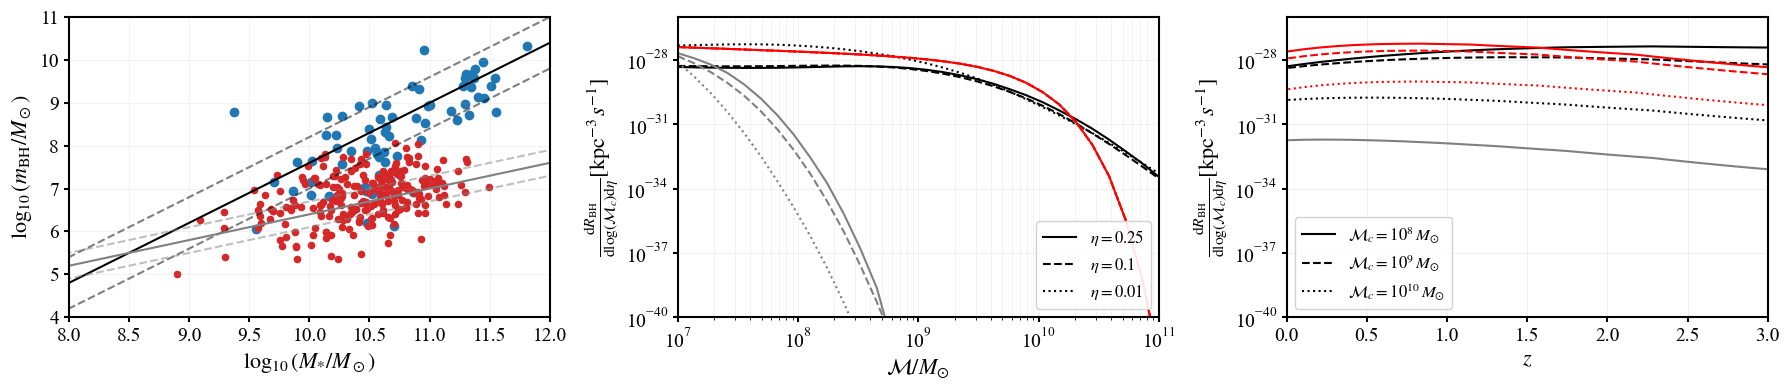

In [161]:
# Create figure with two subplots side-by-side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

# --- LEFT PLOT: SMBH Stellar Mass Relation---
x_meas = np.array([float(m[0][0]) for m in dynamicallymeasured], dtype=np.float64)
y_meas = np.array([float(m[0][1]) for m in dynamicallymeasured], dtype=np.float64)

combined_agn = broadLINEAGNdata 
x_agn = np.array([float(d[0][0]) for d in combined_agn], dtype=np.float64)
y_agn = np.array([float(d[0][1]) for d in combined_agn], dtype=np.float64)
ax1.scatter(x_meas, y_meas,color='tab:blue', label='Measured')
ax1.scatter(x_agn, y_agn, s=20, color='tab:red', label='AGN')

x_line = np.linspace(5, 15, 11)
y_line = 9 + 1.4 * (x_line - 11)
ax1.plot(x_line, y_line,  color='black', label='Best fit')
ax1.plot(x_line, y_line + 0.6,  color='black', linestyle='--',alpha=0.5)
ax1.plot(x_line, y_line - 0.6,  color='black', linestyle='--',alpha=0.5)

x_line = np.linspace(5, 15, 11)
y_line = 7 + 0.6* (x_line - 11)
ax1.plot(x_line, y_line,  color='gray', label='Best fit')
ax1.plot(x_line, y_line + 0.3,  color='gray',linestyle='--', alpha=0.5)
ax1.plot(x_line, y_line - 0.3,  color='gray',linestyle='--',  alpha=0.5)

ax1.set_xlim(8, 12)
ax1.set_ylim(4, 11)
ax1.set_xlabel(r'$\log_{10}\left(M_{*}/M_\odot\right)$', fontsize=16)
ax1.set_ylabel(r'$\log_{10}\left(m_{\rm BH}/M_\odot\right)$', fontsize=16)
ax1.grid(True, alpha=0.2, which='both', linestyle='-', linewidth=0.5)

# --- Center PLOT: BH Merger Rate Scaling ---

ax2.plot(xvalues, yvaluesa, label=r'$\eta=0.25$', color='black',linestyle='solid')
ax2.plot(xvalues, yvalues2a, label=r'$\eta=0.1$', color='black', linestyle='dashed')
ax2.plot(xvalues, yvalues3a, label=r'$\eta=0.01$', color='black', linestyle='dotted')


ax2.plot(xvalues4, yvaluesd, color='gray',linestyle='solid')
ax2.plot(xvalues4, yvalues2d,  color='gray',linestyle='dashed')
ax2.plot(xvalues4, yvalues3d, color='gray',linestyle='dotted')

ax2.plot(xvalues2p, yvalues4p, color='red', linestyle='solid')
ax2.plot(xvalues2p, yvalues5p,  color='red', linestyle='dashed')
ax2.plot(xvalues2p, yvalues6p, color='red', linestyle='dotted')

ax2.set_xlim(1e7, 1e11)
ax2.set_ylim(1e-40, 1e-26)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel(r'$\mathcal{M}/M_{\odot}$', fontsize=16)
ax2.set_ylabel(r'$\frac{{\rm d} R_{\rm BH}}{{\rm d}\log(\mathcal{M}_c){\rm d}\eta}[{\rm kpc^{-3}}\,s^{-1}]$', fontsize=16)
ax2.grid(True, alpha=0.2, which='both', linestyle='-', linewidth=0.5)
ax2.legend(loc='lower right', framealpha=0.9, fontsize=12, frameon=True)
plt.tight_layout()

# --- Right PLOT: BH Merger Rate Scaling ---

ax3.plot(xvalues2, yvaluesb, label=r'$\mathcal{M}_c=10^8\,M_{\odot}$', color='black', linestyle='solid')
ax3.plot(xvalues2, yvalues2b, label=r'$\mathcal{M}_c=10^9\,M_{\odot}$', color='black', linestyle='dashed')
ax3.plot(xvalues2, yvalues3b, label=r'$\mathcal{M}_c=10^{10}\,M_{\odot}$', color='black', linestyle='dotted')

ax3.plot(xvalues3, yvaluesc,  color='gray',linestyle='solid')
ax3.plot(xvalues3, yvalues2c,  color='gray',linestyle='dashed')
ax3.plot(xvalues3, yvalues3c,  color='gray',linestyle='dotted')


ax3.plot(xvaluesp, yvaluesp, color='red', linestyle='solid')
ax3.plot(xvaluesp, yvalues2p,  color='red', linestyle='dashed')
ax3.plot(xvaluesp, yvalues3p, color='red', linestyle='dotted')

ax3.set_xlim(0, 3)
ax3.set_ylim(1e-40, 1e-26)
ax3.set_xscale('linear')
ax3.set_yscale('log')
ax3.set_xlabel(r'$z$', fontsize=16)
ax3.set_ylabel(r'$\frac{{\rm d} R_{\rm BH}}{{\rm d}\log(\mathcal{M}_c){\rm d}\eta}[{\rm kpc^{-3}}\,s^{-1}]$', fontsize=16)
ax3.grid(True, alpha=0.3, which='both', linestyle='-', linewidth=0.5)
ax3.legend(loc='lower left', framealpha=0.9, fontsize=12, frameon=True)
plt.tight_layout()

plt.savefig('/Users/juanurrutia/Desktop/plot_1.pdf', 
            format='pdf', bbox_inches='tight', dpi=300)
plt.show()

In [157]:
# First frequency 
yval1=[dNdlog10Alogf(dR_dlogMcdetaIG, logA, 1e-9, 1, 15*1e-14, 5/8, 8/3, 2**14) for logA in np.linspace(-23, -10, 30)]
yval2=[10**(-3*logA+(np.log10(yval1[-1])-30)) for logA in np.linspace(-23, -10, 30)]

yval3=[dNdlog10Alogf(dR_dlogMcdetaAGN, logA, 1e-9, 1, 15*1e-14, 5/8, 8/3, 2**14) for logA in np.linspace(-23, -10, 30)]
yval4=[10**(-3*logA+(np.log10(yval3[-1])-30)) for logA in np.linspace(-23, -10, 30)]

yval5=[dNdlog10Alogf(Rparam, logA, 1e-9, 1, 15*1e-14, 5/8, 8/3, 2**14) for logA in np.linspace(-23, -10, 30)]
yval6=[10**(-3*logA+(np.log10(yval5[-1])-30)) for logA in np.linspace(-23, -10, 30)]

#Second frequency

yval1b=[dNdlog10Alogf(dR_dlogMcdetaIG, logA, 15*1e-9, 1, 15*1e-14, 5/8, 8/3, 2**14) for logA in np.linspace(-23, -10, 30)]
yval2b=[10**(-3*logA+(np.log10(yval1b[-1])-30)) for logA in np.linspace(-23, -10, 30)]

yval3b=[dNdlog10Alogf(dR_dlogMcdetaAGN, logA, 15*1e-9, 1, 15*1e-14, 5/8, 8/3, 2**14) for logA in np.linspace(-23, -10, 30)]
yval4b=[10**(-3*logA+(np.log10(yval3b[-1])-30)) for logA in np.linspace(-23, -10, 30)]

yval5b=[dNdlog10Alogf(Rparam, logA, 15*1e-9, 1, 15*1e-14, 5/8, 8/3, 2**14) for logA in np.linspace(-23, -10, 30)]
yval6b=[10**(-3*logA+(np.log10(yval5b[-1])-30)) for logA in np.linspace(-23, -10, 30)]

#Third frequency

yval1c=[dNdlog10Alogf(dR_dlogMcdetaIG, logA, 30*1e-9, 1, 15*1e-14, 5/8, 8/3, 2**14) for logA in np.linspace(-23, -10, 30)]
yval2c=[10**(-3*logA+(np.log10(yval1c[-1])-30)) for logA in np.linspace(-23, -10, 30)]

yval3c=[dNdlog10Alogf(dR_dlogMcdetaAGN, logA, 30*1e-9, 1, 15*1e-14, 5/8, 8/3, 2**14) for logA in np.linspace(-23, -10, 30)]
yval4c=[10**(-3*logA+(np.log10(yval3c[-1])-30)) for logA in np.linspace(-23, -10, 30)]

yval5c=[dNdlog10Alogf(Rparam, logA, 30*1e-9, 1, 15*1e-14, 5/8, 8/3, 2**14) for logA in np.linspace(-23, -10, 30)]
yval6c=[10**(-3*logA+(np.log10(yval5c[-1])-30)) for logA in np.linspace(-23, -10, 30)]

xval1=[10**logA for logA in np.linspace(-23, -10, 30)]

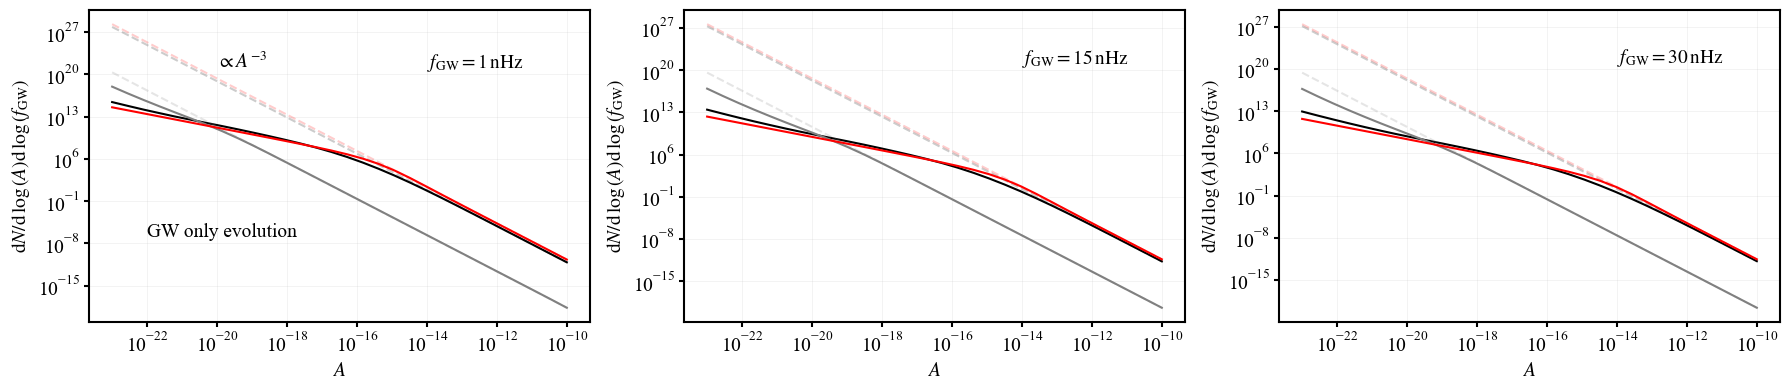

In [162]:
# Create figure with two subplots side-by-side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

# First plot
ax1.plot(xval1, yval1, color='black')
ax1.plot(xval1, yval2, color='black', alpha=0.2, linestyle='dashed')

ax1.plot(xval1, yval3, color='grey')
ax1.plot(xval1, yval4, color='grey', alpha=0.2, linestyle='dashed')

ax1.plot(xval1, yval5, color='red')
ax1.plot(xval1, yval6, color='red', alpha=0.2, linestyle='dashed')

ax1.set_xscale('log')
ax1.set_yscale('log')
# Labels with optional LaTeX formatting - FIXED: use set_xlabel and set_ylabel
ax1.set_xlabel(r'$A$', fontsize=14)
ax1.set_ylabel(r'${\rm d}N/{\rm d}\,\log\left(A\right){\rm d}\,\log\left(f_{\rm GW}\right)}$', fontsize=14) 
# Grid for both major and minor ticks
ax1.grid(True, alpha=0.2, which='both', linestyle='-', linewidth=0.5)
ax1.text(1e-20, 1e21, r'$\propto A^{-3}$', fontsize=14, color='black')
ax1.text(1e-22, 1e-7, 'GW only evolution', fontsize=14, color='black')
ax1.text(1e-14, 1e21, r'$f_{\rm GW}=1\,{\rm nHz}$', fontsize=14, color='black')

# Second plot
ax2.plot(xval1, yval1b, color='black')
ax2.plot(xval1, yval2b, color='black', alpha=0.2, linestyle='dashed')

ax2.plot(xval1, yval3b, color='grey')
ax2.plot(xval1, yval4b, color='grey', alpha=0.2, linestyle='dashed')

ax2.plot(xval1, yval5b, color='red')
ax2.plot(xval1, yval6b, color='red', alpha=0.2, linestyle='dashed')

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel(r'$A$', fontsize=14)
ax2.set_ylabel(r'${\rm d}N/{\rm d}\,\log\left(A\right){\rm d}\,\log\left(f_{\rm GW}\right)}$', fontsize=14) 
# Grid for both major and minor ticks
ax2.grid(True, alpha=0.2, which='both', linestyle='-', linewidth=0.5)
ax2.text(1e-14, 1e21, r'$f_{\rm GW}=15\,{\rm nHz}$', fontsize=14, color='black')

# Third plot
ax3.plot(xval1, yval1c, color='black')
ax3.plot(xval1, yval2c, color='black', alpha=0.2, linestyle='dashed')

ax3.plot(xval1, yval3c, color='grey')
ax3.plot(xval1, yval4c, color='grey', alpha=0.2, linestyle='dashed')

ax3.plot(xval1, yval5c, color='red')
ax3.plot(xval1, yval6c, color='red', alpha=0.2, linestyle='dashed')

ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel(r'$A$', fontsize=14)
ax3.set_ylabel(r'${\rm d}N/{\rm d}\,\log\left(A\right){\rm d}\,\log\left(f_{\rm GW}\right)}$', fontsize=14) 
# Grid for both major and minor ticks
ax3.grid(True, alpha=0.2, which='both', linestyle='-', linewidth=0.5)
ax3.text(1e-14, 1e21, r'$f_{\rm GW}=30\,{\rm nHz}$', fontsize=14, color='black')

plt.tight_layout()
plt.savefig('/Users/juanurrutia/Desktop/plot_2.pdf', 
            format='pdf', bbox_inches='tight', dpi=300)
plt.show()

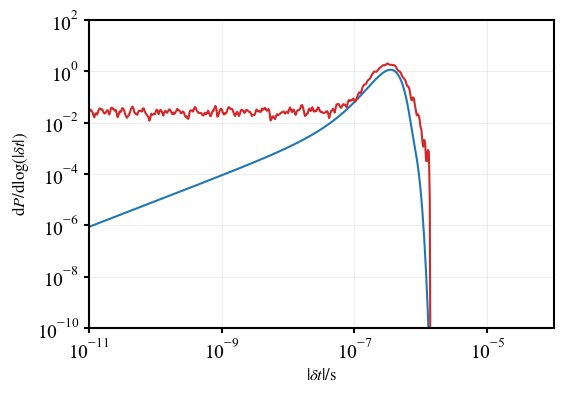

In [118]:
# KDE
kde = gaussian_kde(datf1[0][1]) 
kde.set_bandwidth(bw_method=4)
x = 10**np.linspace(-11,-4, 500)
density = x*kde(x)

x2 = 10**np.linspace(-11,-4, 500)
NANOgrav = PNG15[0][1](np.log10(x2))

# Plot histogram and KDE curve
plt.figure(figsize=(6,4))
plt.plot(x, density, color='tab:blue')
plt.plot(x2, NANOgrav, color='tab:red')
plt.xlim(1e-11, 1e-4)   # Set x-axis range
plt.ylim(1e-10, 1e2)      # Set y-axis range (example values)
# Log scales
plt.xscale('log')
plt.yscale('log')
# Labels with optional LaTeX formatting
plt.xlabel(r'$|\delta t|/{\rm s}$', fontsize=12)
plt.ylabel(r'${\rm d}P/{\rm d}\log(|\delta t|)$', fontsize=12) 
# Grid for both major and minor ticks
plt.grid(True, alpha=0.3, which='both', linestyle='-', linewidth=0.5)
plt.show()